# 서울시 공유자전거 '따릉이' 수요 예측

[목표]
- 서울시 공유 자전거 '따릉이'의 수요와 날씨 간 연관성을 분석
- 어떤 날씨 요소가 따릉이 수요와 관련 있는지 분석하여 인사이트 도출

## ▣ 데이터 소개
[기본 데이터]
* 데이터 : sbikedata.csv

## ▣ 데이터셋의 변수 소개
* date : 날짜
* hour : 시간
* temperature : 온도
* precipitation : 강우 여부, 비가 오지 않았으면 0, 비가 오면 1
* windspeed : 풍속(평균)
* humidity : 습도
* visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone : 오존 수치
* PM10 : 미세먼지 수치(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* PM2.5 : 초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 시간에 따른 따릉이 대여 수

## 1. 환경 설정

#### <span style="color: green"> 1) 라이브러리 불러오기 </span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as spst  
from scipy.interpolate import interpolate  # 보간법

#### <span style="color: green"> 2) 활용할 데이터 불러오기 </span>

In [2]:
data = pd.read_csv('sbikedata.csv')
data

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30
...,...,...,...,...,...,...,...,...,...,...,...
5822,2021-11-29,20,74.0,58.0,0.002,9.3,0,0.3,66,1193,273
5823,2021-11-29,21,65.0,56.0,0.002,8.4,0,2.0,70,1233,228
5824,2021-11-29,22,51.0,41.0,0.002,8.6,0,1.9,70,1250,215
5825,2021-11-29,23,43.0,35.0,0.001,8.2,0,2.1,71,1262,125


#### <span style="color: green"> 3) 데이터 살펴보기 </span>

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
hour,5827.0,11.506607,6.921963,0.000,6.000,12.000,18.000,23.000
PM10,5725.0,31.970655,42.987292,3.000,16.000,25.000,37.000,827.000
PM2.5,5732.0,15.666609,13.850990,1.000,7.000,13.000,20.000,125.000
ozone,5699.0,0.031811,0.018277,0.001,0.019,0.031,0.041,0.137
temperature,5827.0,19.376798,7.501572,-3.500,14.100,20.400,24.900,36.300
precipitation,5827.0,0.075511,0.264236,0.000,0.000,0.000,0.000,1.000
windspeed,5827.0,2.237601,1.054516,0.000,1.500,2.200,2.800,8.300
humidity,5827.0,68.608718,17.277266,19.000,56.000,70.000,82.000,100.000
visibility,5827.0,1758.438648,490.969394,60.000,1935.500,2000.000,2000.000,2000.000
count,5827.0,215.117899,185.972900,1.000,53.000,186.000,315.000,1746.000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5827 entries, 0 to 5826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           5827 non-null   object 
 1   hour           5827 non-null   int64  
 2   PM10           5725 non-null   float64
 3   PM2.5          5732 non-null   float64
 4   ozone          5699 non-null   float64
 5   temperature    5827 non-null   float64
 6   precipitation  5827 non-null   int64  
 7   windspeed      5827 non-null   float64
 8   humidity       5827 non-null   int64  
 9   visibility     5827 non-null   int64  
 10  count          5827 non-null   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 500.9+ KB


## 2. 단변량 분석

1. 변수가 내포하고 있는 의미
2. 변수가 수치형인지, 범주형인지
3. 결측치 존재 여부 및 조치 방안
4. 기초 통계량 확인
5. 데이터 분포 확인
6. 위 정보로부터 파악한 내용 정리
7. 추가 분석사항 도출

### Feature1 : hour

In [5]:
var = 'hour'

In [6]:
data[var].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23,  0], dtype=int64)

In [7]:
data[var].isna().sum()

0

In [8]:
data[var].astype(object).describe()

count     5827
unique      24
top         23
freq       243
Name: hour, dtype: int64

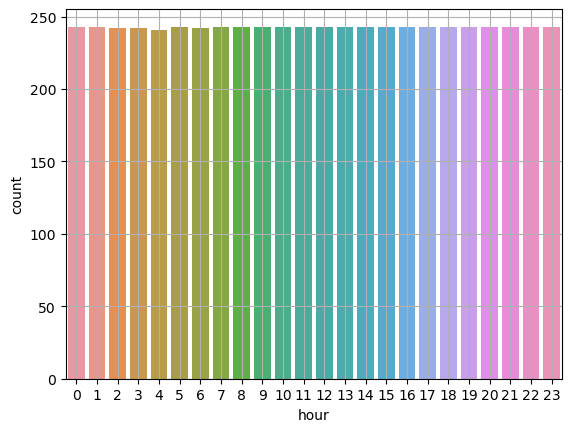

In [9]:
sns.countplot(x=var, data=data)
plt.grid()
plt.show()

In [10]:
print(data[var].value_counts()) # 값과 개수 
# print(data[var].value_counts(normalize=True)) # 비율

23    243
19    243
8     243
12    243
16    243
20    243
1     243
5     243
9     243
13    243
17    243
21    243
10    243
14    243
18    243
22    243
7     243
11    243
15    243
0     243
2     242
6     242
3     242
4     241
Name: hour, dtype: int64


### Feature2 : temperature

In [11]:
var =  'temperature'

In [12]:
data[var].unique()

array([13.1, 12.4, 13. , 12.6, 12. , 14. , 16.2, 18.2, 20.2, 21.7, 22.6,
       23.6, 23.2, 23.5, 23. , 22.3, 20.6, 19.2, 18.1, 16.5, 15.4, 14.6,
       14.2, 13.7, 12.9, 12.8, 12.7, 13.6, 17.4, 18.9, 20.7, 21.6, 22. ,
       22.9, 21. , 19.9, 19.4, 19. , 18.8, 18.4, 18. , 17.7, 17.6, 17.3,
       17.5, 16.8, 15.8, 14.9, 14.8, 14.5, 14.4, 14.3, 13.5, 12.5, 11.7,
       11.4, 10.9, 10.5, 10.3, 10.4, 10.2,  9.7,  9.5,  9.6, 10. , 10.7,
       11.6, 14.7, 15.5, 15. , 12.3,  9. ,  8.1,  7.4,  6.8,  6.5,  6.1,
        5.5,  5.4,  7.9, 16.6, 17.9, 15.9, 13.3, 10.6, 10.8,  9.4, 16.1,
       17. , 18.6, 16. , 15.1, 12.1,  8.7,  8.2,  8.3, 16.7, 19.3, 20.4,
       19.7, 13.8, 11.3, 10.1,  8.9,  7.6,  7.2, 13.9, 17.8, 11.2,  8.6,
        7.8,  7.7,  8.8, 17.2, 19.5, 18.5,  9.8,  9.1,  8. , 15.2, 18.3,
       11.8,  8.4, 12.2, 17.1, 20.8, 21.2, 21.5, 16.9, 11. , 11.1, 11.9,
       11.5,  5.7,  5. ,  4.6,  3.9,  3.4,  3.1,  7.1,  6.6,  6.4,  6.7,
        6.9,  7. ,  7.3,  6.2, 13.2,  5.8,  5.6,  8

In [13]:
data[var].isna().sum()

0

In [14]:
data[var].describe()

count    5827.000000
mean       19.376798
std         7.501572
min        -3.500000
25%        14.100000
50%        20.400000
75%        24.900000
max        36.300000
Name: temperature, dtype: float64

-2.0 36.3


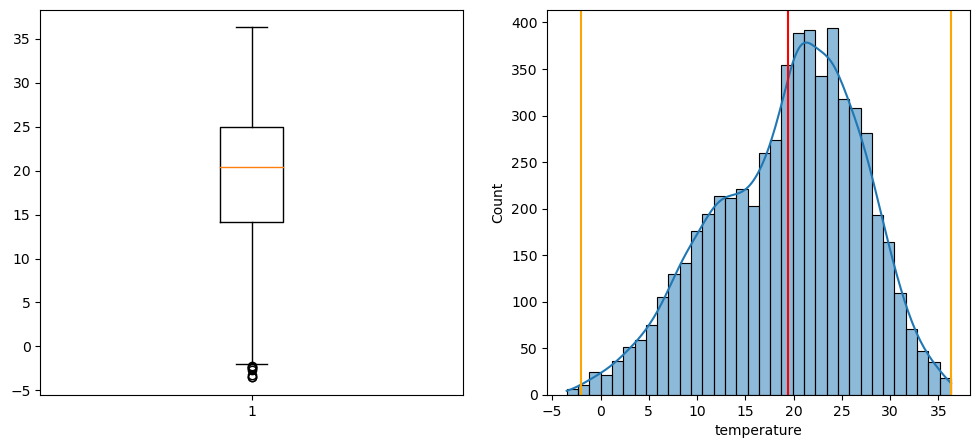

In [15]:
#변수의 분포를 확인해보세요.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
box = plt.boxplot(data[var])
l_fence = box['whiskers'][0].get_ydata()[1]
u_fence = box['whiskers'][1].get_ydata()[1]
print(l_fence, u_fence)

plt.subplot(1, 2, 2)
sns.histplot(data[var], kde = True)
plt.axvline(l_fence, color = 'orange')
avg = data[var].mean()
plt.axvline(avg, color = 'r')
plt.axvline(u_fence, color = 'orange')

plt.show()

### Feature3 : precipitation

In [16]:
var = 'precipitation'

In [17]:
data[var].unique()

array([0, 1], dtype=int64)

In [18]:
data[var].isna().sum()

0

In [19]:
data[var].astype(object).describe()

count     5827
unique       2
top          0
freq      5387
Name: precipitation, dtype: int64

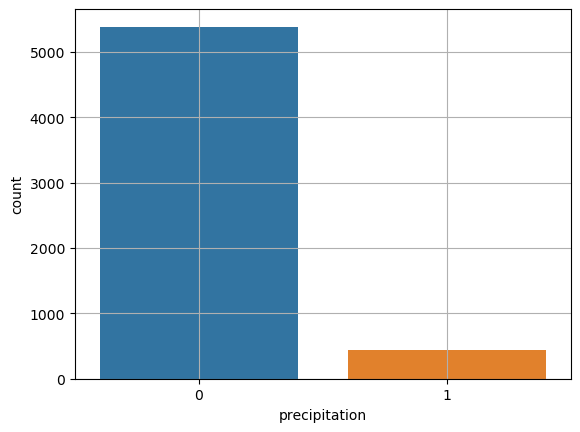

In [20]:
sns.countplot(x=var, data=data)
plt.grid()
plt.show()

In [21]:
print(data[var].value_counts()) # 값과 개수 
print(data[var].value_counts(normalize=True)) # 비율

0    5387
1     440
Name: precipitation, dtype: int64
0    0.924489
1    0.075511
Name: precipitation, dtype: float64
